In [3]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

candle_level = "1m"  # tùy chỉnh
DATA_DIR = f"../../work/data/binance/spot/{candle_level}"
symbols = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT"]  # tùy chỉnh

def load_symbol_csv(sym, data_dir=DATA_DIR, candle_level="1d"):
    # lấy file mới nhất theo tên (khớp mẫu sym_1d_*.csv)
    pattern = os.path.join(data_dir, f"{sym}_{candle_level}_*.csv")
    files = sorted(glob.glob(pattern))
    assert files, f"Không thấy file cho {sym} trong {data_dir}"
    fp = files[-1]
    df = pd.read_csv(fp, parse_dates=["open_time"])
    # chuẩn hóa cột
    df = df.rename(columns={
        "open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume",
        "quote_asset_volume":"QuoteVolume","number_of_trades":"Trades",
        "taker_buy_base_asset_volume":"TakerBuyBase","taker_buy_quote_asset_volume":"TakerBuyQuote"
    })
    df = df.sort_values("open_time").reset_index(drop=True)
    return df, fp

data = {}
for sym in symbols:
    df, fp = load_symbol_csv(sym, candle_level=candle_level)
    data[sym] = {"df": df, "path": fp}
    print(f"[OK] {sym}: {len(df):,} rows | file={os.path.basename(fp)}")


[OK] BTCUSDT: 3,507,322 rows | file=BTCUSDT_1m_2019-01-01_2025-09-04.csv
[OK] ETHUSDT: 3,507,344 rows | file=ETHUSDT_1m_2019-01-01_2025-09-04.csv
[OK] BNBUSDT: 3,507,365 rows | file=BNBUSDT_1m_2019-01-01_2025-09-04.csv
[OK] SOLUSDT: 2,662,968 rows | file=SOLUSDT_1m_2019-01-01_2025-09-04.csv


In [6]:
sol_df = data["SOLUSDT"]["df"]
print("SOL first date:", sol_df["open_time"].iloc[0].date())
print("SOL last date :", sol_df["open_time"].iloc[-1].date())
print("Total days    :", len(sol_df))


SOL first date: 2020-08-11
SOL last date : 2025-09-04
Total days    : 1851


In [7]:
import pandas as pd

def summarize_listing(data_dict, freq="D"):
    rows = []
    for sym, pack in data_dict.items():
        df = pack["df"].copy()
        # ngày đầu/cuối có dữ liệu
        first_ts = df["open_time"].min()
        last_ts  = df["open_time"].max()
        n_bars   = len(df)

        # lưới ngày kỳ vọng (daily)
        full_days = pd.date_range(first_ts.normalize(), last_ts.normalize(), freq=freq)
        have_days = pd.Series(df["open_time"].dt.normalize().unique()).sort_values()
        # ngày thiếu so với lưới (nếu có)
        missing = full_days.difference(have_days)
        miss_cnt = len(missing)

        rows.append({
            "symbol": sym,
            "first_date": first_ts.date(),
            "last_date": last_ts.date(),
            "bars": n_bars,
            "expected_days": len(full_days),
            "missing_days": miss_cnt,
            "coverage_%": round(100 * n_bars / max(1, len(full_days)), 2),
        })

        # in chi tiết
        print(f"== {sym} ==")
        print(f"  First date : {first_ts.date()}")
        print(f"  Last date  : {last_ts.date()}")
        print(f"  Bars       : {n_bars} / expected {len(full_days)}  (coverage: {rows[-1]['coverage_%']}%)")
        if miss_cnt:
            print(f"  Missing {miss_cnt} day(s). Show a few:")
            display(pd.DataFrame({"missing_dates_UTC": missing[:10]}))
        else:
            print("  No missing daily bars detected.")
        print()

    return pd.DataFrame(rows).sort_values("symbol").reset_index(drop=True)

summary_df = summarize_listing(data)
summary_df


== BTCUSDT ==
  First date : 2019-01-01
  Last date  : 2025-09-04
  Bars       : 2439 / expected 2439  (coverage: 100.0%)
  No missing daily bars detected.

== ETHUSDT ==
  First date : 2019-01-01
  Last date  : 2025-09-04
  Bars       : 2439 / expected 2439  (coverage: 100.0%)
  No missing daily bars detected.

== BNBUSDT ==
  First date : 2019-01-01
  Last date  : 2025-09-04
  Bars       : 2439 / expected 2439  (coverage: 100.0%)
  No missing daily bars detected.

== SOLUSDT ==
  First date : 2020-08-11
  Last date  : 2025-09-04
  Bars       : 1851 / expected 1851  (coverage: 100.0%)
  No missing daily bars detected.



,symbol,first_date,last_date,bars,expected_days,missing_days,coverage_%
0,BNBUSDT,2019-01-01,2025-09-04,2439,2439,0,100.0
1,BTCUSDT,2019-01-01,2025-09-04,2439,2439,0,100.0
2,ETHUSDT,2019-01-01,2025-09-04,2439,2439,0,100.0
3,SOLUSDT,2020-08-11,2025-09-04,1851,1851,0,100.0


In [8]:
def sanity_check(df, sym):
    s = df.copy()
    # các field numeric
    num_cols = ["Open","High","Low","Close","Volume","QuoteVolume","Trades","TakerBuyBase","TakerBuyQuote"]
    # cơ bản
    assert s["open_time"].is_monotonic_increasing, f"{sym}: open_time không tăng dần!"
    dup = s["open_time"].duplicated().sum()
    na_cnt = s[num_cols].isna().sum().sum()
    # kiểm tra giá trị âm/bất thường
    neg_cols = [c for c in ["Open","High","Low","Close","Volume"] if (s[c] < 0).any()]
    # khoảng thời gian & missing dates
    start, end = s["open_time"].iloc[0], s["open_time"].iloc[-1]
    # kỳ vọng daily: chênh lệch ~ 1D (nhưng crypto 7d/7d, không nghỉ)
    # detect gaps theo 1 ngày:
    full_range = pd.date_range(start=start.normalize(), end=end.normalize(), freq="D")
    # map open_time về date (UTC)
    by_date = s.set_index("open_time").resample("1D").size()
    gaps = full_range[by_date.reindex(full_range, fill_value=0).values == 0]

    print(f"== {sym} ==")
    print(f"Date range: {start.date()} → {end.date()}  | rows={len(s):,}")
    print(f"Duplicates(open_time): {dup}  | NA in numeric: {na_cnt}")
    print(f"Negative cols: {neg_cols if neg_cols else 'None'}")
    print(f"Missing days (vs full 1D grid): {len(gaps)} {'(show below)' if len(gaps) else ''}")
    if len(gaps) > 0:
        display(pd.DataFrame({"missing_dates_UTC": gaps}))
    # min/max giá & volume
    print("Price/Volume stats:")
    display(s[["Open","High","Low","Close","Volume"]].describe(percentiles=[.01,.05,.5,.95,.99]).T)

for sym in symbols:
    sanity_check(data[sym]["df"], sym)


== BTCUSDT ==
Date range: 2019-01-01 → 2025-09-04  | rows=2,439
Duplicates(open_time): 0  | NA in numeric: 0
Negative cols: None
Missing days (vs full 1D grid): 0 
Price/Volume stats:


,count,mean,std,min,1%,5%,50%,95%,99%,max
Open,2439.0,38488.607388,29869.842580,3398.40000,3592.991400,5353.620000,29992.46000,103468.293000,117395.757000,123306.440000
High,2439.0,39320.490377,30378.836299,3426.45000,3650.247800,5536.700000,30545.18000,105228.553000,118481.534600,124474.000000
Low,2439.0,37612.675588,29339.147852,3349.92000,3534.041800,5227.925000,29450.38000,101333.516000,116033.269800,118920.920000
Close,2439.0,38532.649479,29897.597421,3398.40000,3592.991400,5360.884000,29993.89000,103527.704000,117395.757000,123306.430000
Volume,2439.0,71735.985892,82993.993010,3282.17352,8267.503393,13447.850192,44956.63656,252763.767419,405154.456113,760705.362783


== ETHUSDT ==
Date range: 2019-01-01 → 2025-09-04  | rows=2,439
Duplicates(open_time): 0  | NA in numeric: 0
Negative cols: None
Missing days (vs full 1D grid): 0 
Price/Volume stats:


,count,mean,std,min,1%,5%,50%,95%,99%,max
Open,2439.0,1792.597241,1254.151574,104.4100,119.017400,141.399000,1807.7400,3.870481e+03,4.509494e+03,4.832070e+03
High,2439.0,1844.112681,1289.123334,106.1800,123.536600,145.886000,1841.3400,3.970000e+03,4.623272e+03,4.956780e+03
Low,2439.0,1736.406351,1215.104882,86.0000,114.876000,137.296000,1763.0000,3.734190e+03,4.351897e+03,4.713890e+03
Close,2439.0,1794.353604,1254.825425,104.4500,119.033600,141.749000,1807.8100,3.872432e+03,4.509500e+03,4.832070e+03
Volume,2439.0,605207.840484,456890.339582,58519.6229,118347.423692,173946.805226,479098.0921,1.422283e+06,2.334214e+06,4.663240e+06


== BNBUSDT ==
Date range: 2019-01-01 → 2025-09-04  | rows=2,439
Duplicates(open_time): 0  | NA in numeric: 0
Negative cols: None
Missing days (vs full 1D grid): 0 
Price/Volume stats:


,count,mean,std,min,1%,5%,50%,95%,99%,max
Open,2439.0,3.007365e+02,2.354471e+02,5.4688,6.491588,14.52261,293.1305,6.735890e+02,8.176670e+02,9.002000e+02
High,2439.0,3.084653e+02,2.408139e+02,5.8884,6.643800,15.07173,301.7000,6.892420e+02,8.398582e+02,9.007100e+02
Low,2439.0,2.924073e+02,2.297451e+02,5.3733,6.260944,14.00509,283.4000,6.580190e+02,7.992118e+02,8.755500e+02
Close,2439.0,3.010718e+02,2.356295e+02,5.4688,6.502942,14.53300,293.2600,6.743630e+02,8.240948e+02,9.002100e+02
Volume,2439.0,1.502921e+06,1.698829e+06,49053.1520,95208.939880,153810.81150,891854.5838,4.469488e+06,7.892188e+06,2.018886e+07


== SOLUSDT ==
Date range: 2020-08-11 → 2025-09-04  | rows=1,851
Duplicates(open_time): 0  | NA in numeric: 0
Negative cols: None
Missing days (vs full 1D grid): 0 
Price/Volume stats:


,count,mean,std,min,1%,5%,50%,95%,99%,max
Open,1851.0,8.624219e+01,7.175507e+01,1.1987,1.54255,2.504600e+00,56.81,2.062600e+02,2.417700e+02,2.619700e+02
High,1851.0,8.978139e+01,7.436798e+01,1.3888,1.64475,2.655200e+00,59.37,2.166200e+02,2.496700e+02,2.958300e+02
Low,1851.0,8.270585e+01,6.903946e+01,1.0301,1.45995,2.319500e+00,53.55,1.991150e+02,2.340050e+02,2.526900e+02
Close,1851.0,8.635300e+01,7.178486e+01,1.1980,1.54235,2.505550e+00,56.86,2.065850e+02,2.417750e+02,2.619700e+02
Volume,1851.0,4.462273e+06,3.492126e+06,478921.2600,866376.41000,1.303368e+06,3527634.19,1.107302e+07,1.712349e+07,3.496502e+07


In [9]:
def add_returns(df):
    s = df.copy()
    s["Ret"] = s["Close"].pct_change()
    s["LogRet"] = np.log(s["Close"]).diff()
    return s

for sym in symbols:
    data[sym]["df_ret"] = add_returns(data[sym]["df"])

def returns_summary(sym):
    s = data[sym]["df_ret"]
    print(f"== {sym} returns stats ==")
    out = {
        "n": s["LogRet"].dropna().shape[0],
        "mean_logret": s["LogRet"].mean(),
        "std_logret": s["LogRet"].std(),
        "annualized_mean": s["LogRet"].mean() * 365,
        "annualized_vol": s["LogRet"].std() * np.sqrt(365),
        "min_ret": s["Ret"].min(),
        "max_ret": s["Ret"].max()
    }
    display(pd.Series(out))

for sym in symbols:
    returns_summary(sym)


== BTCUSDT returns stats ==


n                  2438.000000
mean_logret           0.001384
std_logret            0.033808
annualized_mean       0.505313
annualized_vol        0.645910
min_ret              -0.395048
max_ret               0.195361
dtype: float64

== ETHUSDT returns stats ==


n                  2438.000000
mean_logret           0.001417
std_logret            0.044198
annualized_mean       0.517378
annualized_vol        0.844408
min_ret              -0.445969
max_ret               0.263329
dtype: float64

== BNBUSDT returns stats ==


n                  2438.000000
mean_logret           0.002031
std_logret            0.045119
annualized_mean       0.741455
annualized_vol        0.861998
min_ret              -0.441381
max_ret               0.703021
dtype: float64

== SOLUSDT returns stats ==


n                  1850.000000
mean_logret           0.002241
std_logret            0.063385
annualized_mean       0.817927
annualized_vol        1.210973
min_ret              -0.422477
max_ret               0.458712
dtype: float64

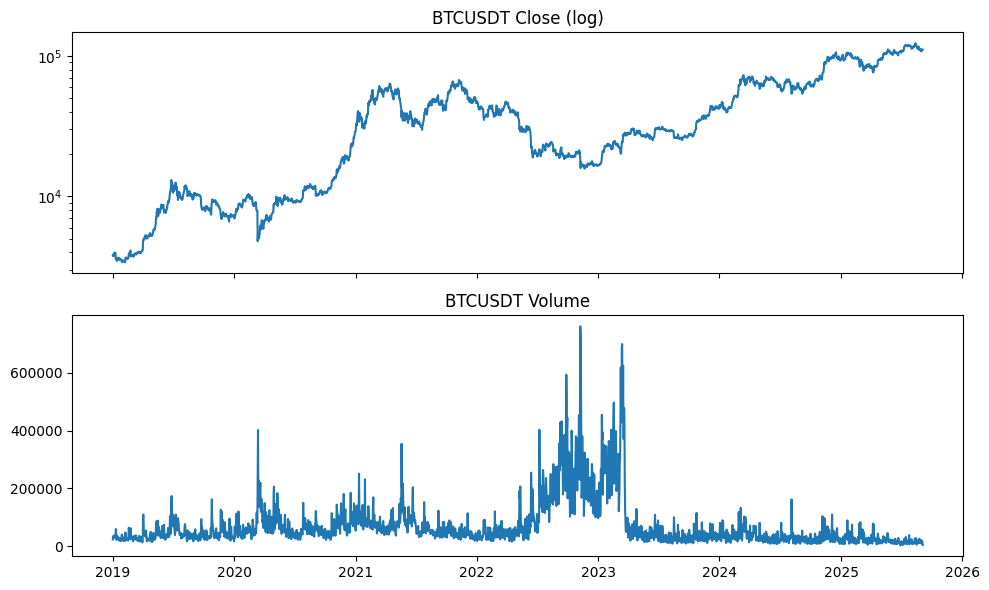

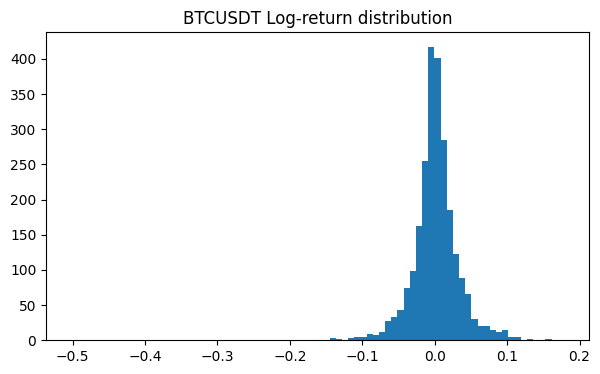

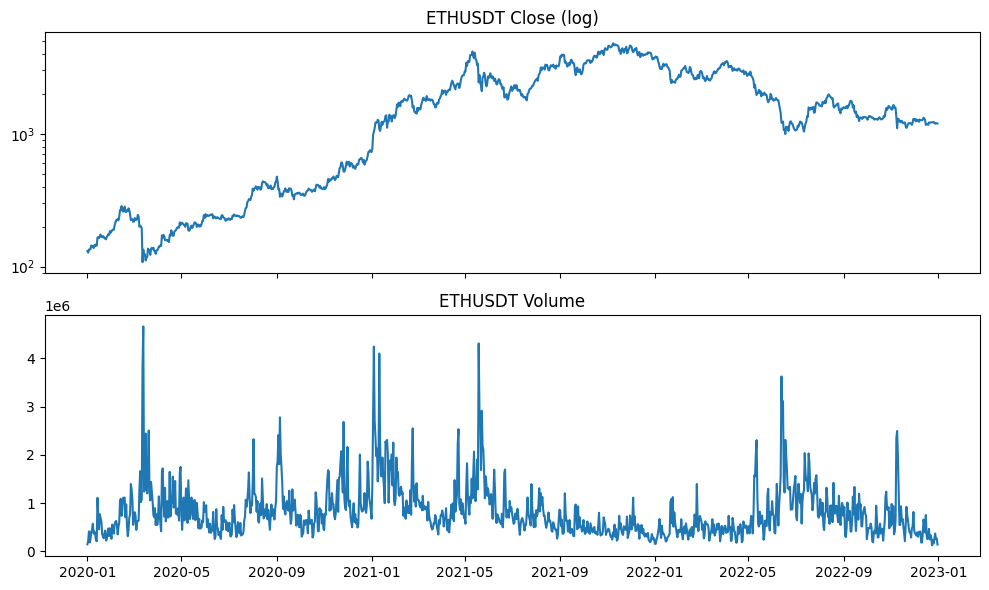

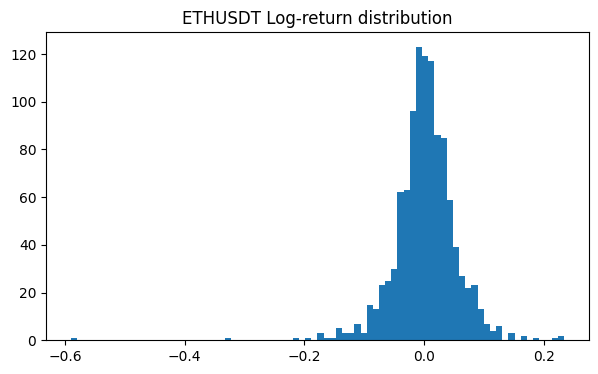

In [12]:
def plot_price_volume(sym, start=None, end=None):
    s = data[sym]["df"]
    if start or end:
        if start:
            start = pd.to_datetime(start).tz_localize("UTC")
        if end:
            end = pd.to_datetime(end).tz_localize("UTC")
        s = s[(s["open_time"] >= (start if start else s["open_time"].min())) &
              (s["open_time"] <= (end if end else s["open_time"].max()))]

    fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True)
    axs[0].plot(s["open_time"], s["Close"])
    axs[0].set_yscale("log")
    axs[0].set_title(f"{sym} Close (log)")

    axs[1].plot(s["open_time"], s["Volume"])
    axs[1].set_title(f"{sym} Volume")
    plt.tight_layout()
    plt.show()


def plot_returns(sym, start=None, end=None):
    s = data[sym]["df_ret"]
    if start or end:
        if start:
            start = pd.to_datetime(start).tz_localize("UTC")
        if end:
            end = pd.to_datetime(end).tz_localize("UTC")
        s = s[(s["open_time"] >= (start if start else s["open_time"].min())) &
              (s["open_time"] <= (end if end else s["open_time"].max()))]

    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(s["LogRet"].dropna(), bins=80)
    ax.set_title(f"{sym} Log-return distribution")
    plt.show()


# ví dụ:
plot_price_volume("BTCUSDT")
plot_returns("BTCUSDT")

# ví dụ chọn khoảng:
plot_price_volume("ETHUSDT", start="2020-01-01", end="2022-12-31")
plot_returns("ETHUSDT", start="2020-01-01", end="2022-12-31")


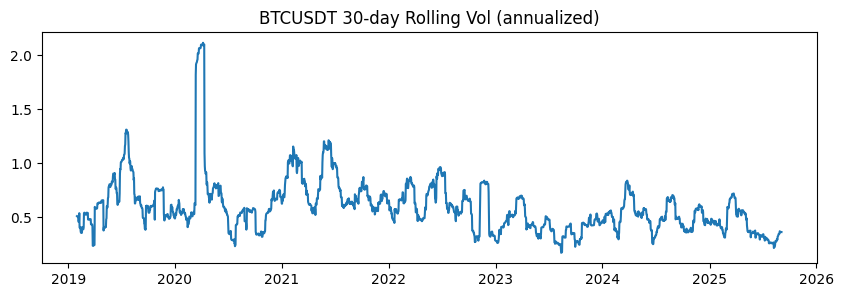

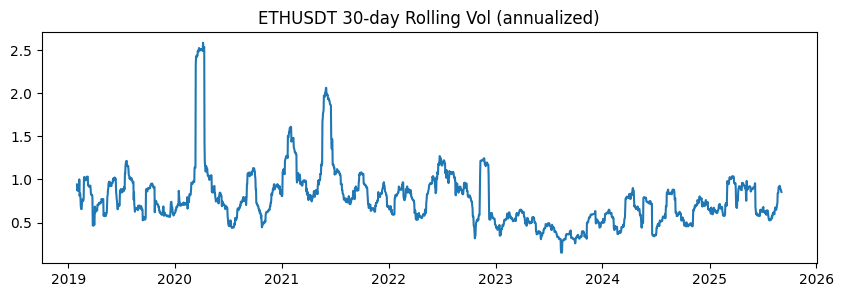

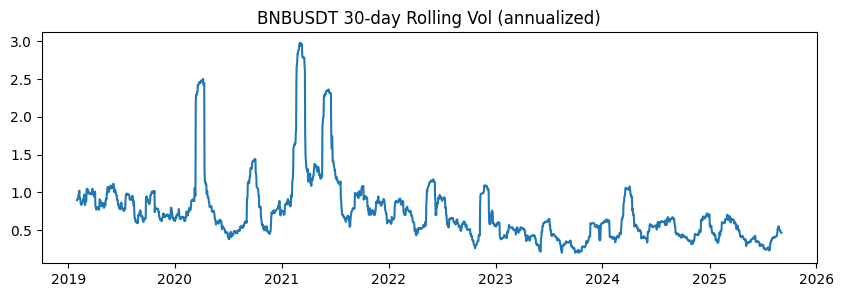

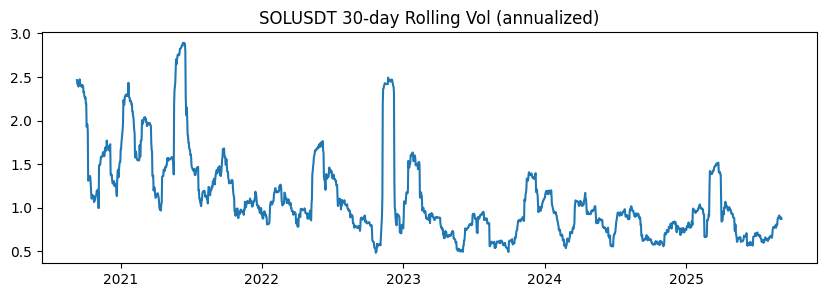

In [13]:
def plot_rolling_vol(sym, window=30):
    s = data[sym]["df_ret"].copy()
    s["rolling_vol"] = s["LogRet"].rolling(window).std() * np.sqrt(365)
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(s["open_time"], s["rolling_vol"])
    ax.set_title(f"{sym} {window}-day Rolling Vol (annualized)")
    plt.show()

for sym in symbols:
    plot_rolling_vol(sym, window=30)


In [14]:
# merge log-returns theo cột
rets = []
for sym in symbols:
    s = data[sym]["df_ret"][["open_time","LogRet"]].copy()
    s = s.rename(columns={"LogRet": sym})
    rets.append(s)
rets_df = rets[0]
for s in rets[1:]:
    rets_df = rets_df.merge(s, on="open_time", how="inner")

corr = rets_df[symbols].corr()
corr


,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT
BTCUSDT,1.000000,0.804668,0.649984,0.567139
ETHUSDT,0.804668,1.000000,0.671076,0.639229
BNBUSDT,0.649984,0.671076,1.000000,0.563979
SOLUSDT,0.567139,0.639229,0.563979,1.000000


In [15]:
def detect_spikes(sym, z=5.0):
    s = data[sym]["df_ret"].copy()
    # spike returns
    mu, sd = s["LogRet"].mean(), s["LogRet"].std()
    s["zret"] = (s["LogRet"] - mu) / (sd + 1e-12)
    spike_ret = s.loc[s["zret"].abs() >= z, ["open_time","LogRet","zret"]]

    # spike volume
    vmu, vsd = s["Volume"].mean(), s["Volume"].std()
    s["zvol"] = (s["Volume"] - vmu) / (vsd + 1e-12)
    spike_vol = s.loc[s["zvol"].abs() >= z, ["open_time","Volume","zvol"]]

    print(f"== {sym} spikes (|z|>={z}) ==")
    print("Returns spikes:")
    display(spike_ret.sort_values("open_time").tail(10))
    print("Volume spikes:")
    display(spike_vol.sort_values("open_time").tail(10))

for sym in symbols:
    detect_spikes(sym, z=5.0)


== BTCUSDT spikes (|z|>=5.0) ==
Returns spikes:


,open_time,LogRet,zret
436,2020-03-12 00:00:00+00:00,-0.502607,-14.907259
769,2021-02-08 00:00:00+00:00,0.178449,5.237274


Volume spikes:


,open_time,Volume,zvol
1366,2022-09-28 00:00:00+00:00,521385.455470,5.417856
1407,2022-11-08 00:00:00+00:00,760705.362783,8.301437
1408,2022-11-09 00:00:00+00:00,731926.929729,7.954683
1409,2022-11-10 00:00:00+00:00,608448.364320,6.466882
1508,2023-02-17 00:00:00+00:00,496813.213760,5.121783
1529,2023-03-10 00:00:00+00:00,618456.467100,6.587471
1532,2023-03-13 00:00:00+00:00,687889.312590,7.424071
1533,2023-03-14 00:00:00+00:00,699360.934230,7.562294
1534,2023-03-15 00:00:00+00:00,581450.729840,6.141586
1536,2023-03-17 00:00:00+00:00,624460.680910,6.659816


== ETHUSDT spikes (|z|>=5.0) ==
Returns spikes:


,open_time,LogRet,zret
436,2020-03-12 00:00:00+00:00,-0.590534,-13.393075
733,2021-01-03 00:00:00+00:00,0.233501,5.250950
869,2021-05-19 00:00:00+00:00,-0.324861,-7.382135
874,2021-05-24 00:00:00+00:00,0.233750,5.256592


Volume spikes:


,open_time,Volume,zvol
436,2020-03-12 00:00:00+00:00,3.814533e+06,7.024279
437,2020-03-13 00:00:00+00:00,4.663240e+06,8.881851
734,2021-01-04 00:00:00+00:00,4.245011e+06,7.966470
741,2021-01-11 00:00:00+00:00,4.099451e+06,7.647881
869,2021-05-19 00:00:00+00:00,4.309836e+06,8.108354
870,2021-05-20 00:00:00+00:00,2.942778e+06,5.116261
873,2021-05-23 00:00:00+00:00,2.914549e+06,5.054475
1259,2022-06-13 00:00:00+00:00,3.626352e+06,6.612405
1261,2022-06-15 00:00:00+00:00,3.114823e+06,5.492818


== BNBUSDT spikes (|z|>=5.0) ==
Returns spikes:


,open_time,LogRet,zret
436,2020-03-12 00:00:00+00:00,-0.582287,-12.950598
770,2021-02-09 00:00:00+00:00,0.296074,6.517031
778,2021-02-17 00:00:00+00:00,0.238962,5.251229
780,2021-02-19 00:00:00+00:00,0.532404,11.754962
781,2021-02-20 00:00:00+00:00,-0.275086,-6.141923
869,2021-05-19 00:00:00+00:00,-0.416712,-9.280854
874,2021-05-24 00:00:00+00:00,0.281951,6.204018
902,2021-06-21 00:00:00+00:00,-0.225003,-5.031903


Volume spikes:


,open_time,Volume,zvol
771,2021-02-10 00:00:00+00:00,1.661353e+07,8.894724
778,2021-02-17 00:00:00+00:00,1.018566e+07,5.111016
779,2021-02-18 00:00:00+00:00,1.122689e+07,5.723927
780,2021-02-19 00:00:00+00:00,2.018886e+07,10.999305
781,2021-02-20 00:00:00+00:00,1.349766e+07,7.060591
782,2021-02-21 00:00:00+00:00,1.064642e+07,5.382238
783,2021-02-22 00:00:00+00:00,1.260440e+07,6.534783
784,2021-02-23 00:00:00+00:00,1.587977e+07,8.462799
785,2021-02-24 00:00:00+00:00,1.177783e+07,6.048228
869,2021-05-19 00:00:00+00:00,1.149773e+07,5.883353


== SOLUSDT spikes (|z|>=5.0) ==
Returns spikes:


,open_time,LogRet,zret
29,2020-09-09 00:00:00+00:00,0.377554,5.921140
281,2021-05-19 00:00:00+00:00,-0.469936,-7.449320
820,2022-11-09 00:00:00+00:00,-0.549008,-8.696804


Volume spikes:


,open_time,Volume,zvol
196,2021-02-23 00:00:00+00:00,2.430632e+07,5.682511
281,2021-05-19 00:00:00+00:00,2.225997e+07,5.096521
285,2021-05-23 00:00:00+00:00,2.578715e+07,6.106559
392,2021-09-07 00:00:00+00:00,2.437649e+07,5.702604
819,2022-11-08 00:00:00+00:00,2.815684e+07,6.785141
820,2022-11-09 00:00:00+00:00,3.496502e+07,8.734720
821,2022-11-10 00:00:00+00:00,3.127828e+07,7.678991
886,2023-01-14 00:00:00+00:00,2.599723e+07,6.166718
1455,2024-08-05 00:00:00+00:00,2.426756e+07,5.671411
1622,2025-01-19 00:00:00+00:00,2.505167e+07,5.895948
